# Classifying Yelp Reviews (Classifying Sentiment of Restaurant Reviews, chapter 3) 

### Source: Chapter 3, Natural Language Processing with Pytorch. (2019). Delip Rao and Brian McMahan. O’Reilly: source code available on https://github.com/joosthub/PyTorchNLPBook

### PyTorch tutorial: refer to https://pytorch.org/tutorials/

## Imports

In [1]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string
import contractions
import inflect

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

#added import nltk
import nltk
from nltk.corpus import stopwords, words
from nltk import word_tokenize
wnl = nltk.WordNetLemmatizer()
correct_words = words.words()

In [2]:
# # loop for finding correct spellings
# # based on edit distance and
# # printing the correct words

# #Define the list of incorrect_words for which we need the correct spellings. 
# #Then run a loop for each word in the incorrect words list to 
# #calculate the Edit distance of the incorrect word with each correct spelling word having the same initial letter.
# #Then sort them in ascending order so the shortest distance is on top and extract the word corresponding to it and print it.
# def incorrect_wordCheck(word):
#     if word in correct_words:
#         return word
#     else:
#         temp = [(edit_distance(word, w),w) for w in correct_words if w[0]==word[0]]
#         try:
#             word = sorted(temp, key = lambda val:val[0])[0][1]
#         except:
#             return word #unable to find a correct word
#         return word
# print(incorrect_wordCheck('happpy'))
        

## Data Vectorization classes

In [3]:
def processingText(myString):
    myString = re.sub(r'\d+', '', myString) #remove numbers
    #trantab = str.maketrans(string.punctuation, " "*32) #remove punctuation
    #myString = myString.translate(trantab)
    #myString = re.sub(r'\s+', ' ', myString) # \s+ matches a whitespace character whose length is 1 or more than 1.
    myString = myString.strip() # removing trailing whitespaces
    myString = re.sub(r'\[[^]]*\]', '', myString) # remove between square brackets # [^]]* : match anything except ']'
    return myString

### The Vocabulary

In [4]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """
        
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx         # _token_to_idx: {'<UNK>':0, 'apple':1, 'banana':2, ....., 'zzz':10000}
                                                  # _idx_to_token: {0:'<UNK>', 1:'apple', 2:'banana', ....., 10000:'zzz'}

        self._idx_to_token = \
        {idx: wnl.lemmatize(contractions.fix((re.sub(r'(?!<\d)\.(?!\d)|[^\s\w.]',token.lower())))) \
        for token, idx in self._token_to_idx.items() if not stopwords.words('english')} 
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
              
    def add_token(self, token): #added: modify to skip token
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        
        token = re.sub(r'(?!<\d)\.(?!\d)|[^\s\w.]', '', token.lower())  #added
        if token in stopwords.words('english'):#added
            return -1
        token = wnl.lemmatize(contractions.fix(token))
        if token in self._token_to_idx: 
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:                   # if unk_token is defined, unknown words are handled
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)
    
    def show(self):#added
        print(self._token_to_idx)
        

### The Vectorizer

In [5]:
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, review_vocab, rating_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers; {'negative':0, 'positive':1}
        """
        self.review_vocab = review_vocab     # {'<UNK>':0, 'apple':1, 'banana':2, ....., 'zzz':10000}
        self.rating_vocab = rating_vocab     # {'negative':0, 'positive':1}

    def vectorize(self, review):
        """Create a collapsed one-hot vector for the review
        
        Args:
            review (str): the review 
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding   
        """
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
        #review = processingText(review) #add text preprocessing
        for token in review.split(" "):
            
            token = re.sub(r'(?!<\d)\.(?!\d)|[^\s\w.]', '', token.lower()) #added regex
            token = wnl.lemmatize(contractions.fix(token))
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1
            else:
                one_hot[self.review_vocab.lookup_token(token)] +=1
        #implemented a word vector
        return one_hot  # E.g., "Unfortunately, the frustration of being Dr. Go..." -> [0, 0, 1, 0, 1, ....., 0, 0]

    @classmethod
    def from_dataframe(cls, review_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            cls: class name, i.e. ReviewVectorizer
            review_df (pandas.DataFrame): the review dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the ReviewVectorizer
        """
        #print("This is the review_df", review_df)
        
        review_vocab = Vocabulary(add_unk=True)   # create an instance of Vocabulary class
        rating_vocab = Vocabulary(add_unk=False)
        
        # Add ratings
        for rating in sorted(set(review_df.rating)):  
            rating_vocab.add_token(rating)            # {'negative':0, 'positive':1}

        # Add top words if count > provided count
        word_counts = Counter()
        for review in review_df.review:
            #review = processingText(review) #add text preprocessing
            for word in review.split(" "):
                if word not in string.punctuation: #and not stopwords.words('english'): #added
                    word = re.sub(r'(?!<\d)\.(?!\d)|[^\s\w.]', '', word.lower()) #added regex
                    word = wnl.lemmatize(contractions.fix(word))
                    word_counts[word] += 1 #added
        
        word_counts = {word: count for word, count in word_counts.items() if word not in stopwords.words('english')}
        for word, count in word_counts.items():#for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)          # {'<UNK>':0, 'apple':1, 'banana':2, ....., 'zzz':10000}
        #review_vocab.show() #added
            
        return cls(review_vocab, rating_vocab)

In [6]:
# # print("Loading dataset and creating vectorizer")
# # create dataset and vectorizer
# dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv, args.frequency_cutoff) 

# vectorizer = dataset.get_vectorizer()

# classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab), hidden_dim=args.hidden_dim)
#dataset._vectorizer.review_vocab._token_to_idx

### The Dataset

In [7]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
            review_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv, frequency_cutoff):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            cls: class name, i.e. ReviewDataset
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df, frequency_cutoff))
    
    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        review_vector = \
            self._vectorizer.vectorize(row.review)

        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector,           #  e.g., { 'x_data': [0, 0, 1, 0, 1, ....., 0, 0],
                'y_target': rating_index}          #          'y_target': 0  }

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  # the floor division // rounds the result down to the nearest whole number
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    # drop_last: set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size. 
    # If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)
    # need to use sampler option for balanced data: 
    # https://discuss.pytorch.org/t/balanced-sampling-between-classes-with-torchvision-dataloader/2703
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)
    
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():  # name: x_data & y_target
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## The Model: ReviewClassifier

In [8]:
class ReviewClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, num_features, hidden_dim):
        """
        Args:
            num_features (int): the size of the input feature vector
            hidden_dim   (int): the size of hidden dimension
        """
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, out_features=100, bias = True) 
        self.fc2 = nn.Linear(in_features=100, out_features=1, bias = True)
        #self.fc3 = nn.Linear(in_features=15, out_features=5, bias = True)
        #self.bn1 = nn.BatchNorm1d(20)
        #self.bn2 = nn.BatchNorm1d(15)
        #self.bn3 = nn.BatchNorm1d(15)
        self.dpout = nn.Dropout(p=0.5)

    def forward(self, x_in):
        """The forward pass of the classifier    
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be [batch, num_features]
        Returns:
            the resulting tensor. tensor.shape should be [batch]
        """
        intermediate = self.fc1(x_in)            # [batch, num_features] -> [batch, hidden_dim]
        #intermediate = self.bn1(intermediate)
        intermediate = F.relu(intermediate)      # [batch, hidden_dim]
        intermediate = self.dpout(intermediate)
        #intermediate = self.i1(intermediate)
        #intermediate = self.bn2(intermediate)
        #intermediate = F.relu(intermediate)
        #intermediate = self.dpout(intermediate)
        #intermediate = self.i2(intermediate)
        y_out = self.fc2(intermediate)           # [batch, hidden_dim] -> [batch, out_features]
        
               
        return torch.sigmoid(y_out).squeeze()    # [batch, 1] -> [batch] (e.g., [0.3, 0.1, 0.7, 0.8, ..., 0.5])

## Training Routine

### Helper functions

In [9]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t  # update 'early_stopping_best_val'

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (y_pred>0.5).cpu().long()
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()  # item() to get a Python number from a tensor containing a single value
    return n_correct / len(y_pred_indices) * 100

#### General utilities

In [10]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### Settings and some prep work

In [11]:
args = Namespace(
    # Data and Path information
    frequency_cutoff=0,
    model_state_file='model.pth',
    review_csv='data/yelp/reviews_with_splits_lite.csv',
    save_dir='model_storage/ch3/yelp/',
    # No Model hyper parameters
    hidden_dim=20,
    # Training hyper parameters
    batch_size=128, #was 128
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=1337,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)    
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs ; creat dirs if they don't exist
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch3/yelp/model.pth
Using CUDA: False


### Initializations

In [12]:
print("Loading dataset and creating vectorizer")
# create dataset and vectorizer
dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv, args.frequency_cutoff) 
print("preparing vectorizer")
vectorizer = dataset.get_vectorizer()
print("Preparing classifier")
classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab), hidden_dim=args.hidden_dim)

Loading dataset and creating vectorizer
preparing vectorizer
Preparing classifier


In [13]:
str(vectorizer.review_vocab), str(vectorizer.rating_vocab)

('<Vocabulary(size=34034)>', '<Vocabulary(size=2)>')

### Training loop

1. lr_scheduler.ReduceLROnPlateau(): Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.(https://pytorch.org/docs/stable/optim.html)
> - mode (str) – One of min, max. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; in max mode it will be reduced when the quantity monitored has stopped increasing. Default: ‘min’.<br>
>- factor (float) – Factor by which the learning rate will be reduced. new_lr = lr * factor. Default: 0.1.<br>
>- patience (int) – Number of epochs with no improvement after which learning rate will be reduced. For example, if patience = 2, then we will ignore the first 2 epochs with no improvement, and will only decrease the LR after the 3rd epoch if the loss still hasn’t improved then. Default: 10.

In [14]:
classifier = classifier.to(args.device)

loss_func = nn.BCELoss()
#AdamW is slightly better                           # was 0.001
optimizer = optim.AdamW(classifier.parameters(), lr=0.001) #tune from 0.001, , weight_decay=0.001
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.1,
                                                 patience=10) # Reduce learning rate when a metric has stopped improving.

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)  # progress bar

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            
            
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())  # [batch, num_features] -> [batch]

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # update bar
            train_bar.set_postfix(loss=running_loss, 
                                  acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()
        
        train_state['train_loss'].append(running_loss)  # train_loss for each epoch
        train_state['train_acc'].append(running_acc)    # train_acc for each epoch

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, 
                                acc=running_acc, 
                                epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)  # val_loss for each epoch
        train_state['val_acc'].append(running_acc)    # val_acc for each epoch

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])  # adjust learning rate

        train_bar.n = 0  # Number of finished iterations
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break

        train_bar.n = 1   # reset number of finished iterations
        val_bar.n = 1
except KeyboardInterrupt:
    print("Exiting loop")

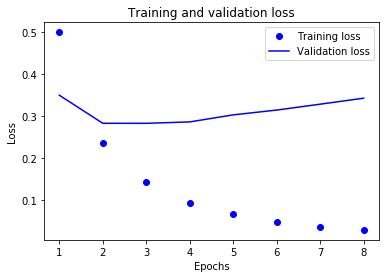

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

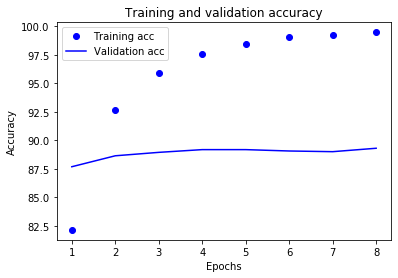

In [16]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

y_pred_list = []    # store predicted values for confusion matrix
y_target_list = []  # ground truth value

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())
    
    # store predicted values and ground truth values for calculating confusion matrix
    y_pred_list.extend((y_pred>0.5).cpu().long().numpy())
    y_target_list.extend(batch_dict['y_target'].cpu().numpy())
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [18]:
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 0.267
Test Accuracy: 89.96


In [19]:
rating_classes = []
for i in range(len(dataset._vectorizer.rating_vocab)):
    rating_classes.append(dataset._vectorizer.rating_vocab.lookup_index(i))
print(rating_classes)

['negative', 'positive']


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
cm = confusion_matrix(y_target_list, y_pred_list)
cm_df = pd.DataFrame(cm.T, index=rating_classes, columns=rating_classes)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True       negative  positive
Predicted                    
negative        750        84
positive         83       747


In [21]:
print(classification_report(y_target_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       833
           1       0.90      0.90      0.90       831

    accuracy                           0.90      1664
   macro avg       0.90      0.90      0.90      1664
weighted avg       0.90      0.90      0.90      1664



In [22]:
# #create my own test loop
# def loop(tuningPara):
#     args = Namespace(
#     # Data and Path information
#     frequency_cutoff=25,
#     model_state_file='model.pth',
#     review_csv='data/yelp/reviews_with_splits_lite.csv',
#     save_dir='model_storage/ch3/yelp/',
#     # No Model hyper parameters
#     hidden_dim=20,
#     # Training hyper parameters
#     batch_size=128,
#     early_stopping_criteria=5,
#     learning_rate=0.001,
#     num_epochs=100,
#     seed=1337,
#     # Runtime options
#     catch_keyboard_interrupt=True,
#     cuda=True,
#     expand_filepaths_to_save_dir=True,
#     reload_from_files=False,
#     )

#     if args.expand_filepaths_to_save_dir:
#         args.model_state_file = os.path.join(args.save_dir,
#                                              args.model_state_file)    
#     #    print("Expanded filepaths: ")
#     #    print("\t{}".format(args.model_state_file))

#     # Check CUDA
#     if not torch.cuda.is_available():
#         args.cuda = False

#     #print("Using CUDA: {}".format(args.cuda))

#     args.device = torch.device("cuda" if args.cuda else "cpu")

#     # Set seed for reproducibility
#     set_seed_everywhere(args.seed, args.cuda)

#     # handle dirs ; creat dirs if they don't exist
#     handle_dirs(args.save_dir)
    
#     ##
#     print("Loading dataset and creating vectorizer")
# # create dataset and vectorizer
#     dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv, args.frequency_cutoff) 

#     vectorizer = dataset.get_vectorizer()

#     classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab), hidden_dim=args.hidden_dim)
#     ##
#     classifier = classifier.to(args.device)

#     loss_func = nn.BCELoss()
#     optimizer = optim.Adam(classifier.parameters(), lr=tuningPara) #tune from 0.001
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
#                                                      mode='min', factor=0.1,
#                                                      patience=10) # Reduce learning rate when a metric has stopped improving.

#     train_state = make_train_state(args)

#     epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)  # progress bar

#     dataset.set_split('train')
#     train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

#     dataset.set_split('val')
#     val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

#     try:
#         for epoch_index in range(args.num_epochs):
#             train_state['epoch_index'] = epoch_index

#             # Iterate over training dataset

#             # setup: batch generator, set loss and acc to 0, set train mode on
#             dataset.set_split('train')
#             batch_generator = generate_batches(dataset, 
#                                                batch_size=args.batch_size, 
#                                                device=args.device)
#             running_loss = 0.0
#             running_acc = 0.0
#             classifier.train()

#             for batch_index, batch_dict in enumerate(batch_generator):
#                 # the training routine is these 5 steps:

#                 # --------------------------------------
#                 # step 1. zero the gradients
#                 optimizer.zero_grad()

#                 # step 2. compute the output
#                 y_pred = classifier(x_in=batch_dict['x_data'].float())  # [batch, num_features] -> [batch]

#                 # step 3. compute the loss
#                 loss = loss_func(y_pred, batch_dict['y_target'].float())
#                 loss_t = loss.item()
#                 running_loss += (loss_t - running_loss) / (batch_index + 1)

#                 # step 4. use loss to produce gradients
#                 loss.backward()

#                 # step 5. use optimizer to take gradient step
#                 optimizer.step()
#                 # -----------------------------------------
#                 # compute the accuracy
#                 acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
#                 running_acc += (acc_t - running_acc) / (batch_index + 1)

#                 # update bar
#                 train_bar.set_postfix(loss=running_loss, 
#                                       acc=running_acc, 
#                                       epoch=epoch_index)
#                 train_bar.update()

#             train_state['train_loss'].append(running_loss)  # train_loss for each epoch
#             train_state['train_acc'].append(running_acc)    # train_acc for each epoch

#             # Iterate over val dataset

#             # setup: batch generator, set loss and acc to 0; set eval mode on
#             dataset.set_split('val')
#             batch_generator = generate_batches(dataset, 
#                                                batch_size=args.batch_size, 
#                                                device=args.device)
#             running_loss = 0.
#             running_acc = 0.
#             classifier.eval()

#             for batch_index, batch_dict in enumerate(batch_generator):

#                 # compute the output
#                 y_pred = classifier(x_in=batch_dict['x_data'].float())

#                 # step 3. compute the loss
#                 loss = loss_func(y_pred, batch_dict['y_target'].float())
#                 loss_t = loss.item()
#                 running_loss += (loss_t - running_loss) / (batch_index + 1)

#                 # compute the accuracy
#                 acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
#                 running_acc += (acc_t - running_acc) / (batch_index + 1)

#                 val_bar.set_postfix(loss=running_loss, 
#                                     acc=running_acc, 
#                                     epoch=epoch_index)
#                 val_bar.update()

#             train_state['val_loss'].append(running_loss)  # val_loss for each epoch
#             train_state['val_acc'].append(running_acc)    # val_acc for each epoch

#             train_state = update_train_state(args=args, model=classifier,
#                                              train_state=train_state)

#             scheduler.step(train_state['val_loss'][-1])  # adjust learning rate

#             train_bar.n = 0  # Number of finished iterations
#             val_bar.n = 0
#             epoch_bar.update()

#             if train_state['stop_early']:
#                 break

#             train_bar.n = 1   # reset number of finished iterations
#             val_bar.n = 1
#             epoch_bar.update()
#     except KeyboardInterrupt:
#         print("Exiting loop")
#     # compute the loss & accuracy on the test set using the best available model

#     classifier.load_state_dict(torch.load(train_state['model_filename']))
#     classifier = classifier.to(args.device)

#     dataset.set_split('test')
#     batch_generator = generate_batches(dataset, 
#                                        batch_size=args.batch_size, 
#                                        device=args.device)
#     running_loss = 0.
#     running_acc = 0.
#     classifier.eval()

#     y_pred_list = []    # store predicted values for confusion matrix
#     y_target_list = []  # ground truth value

#     for batch_index, batch_dict in enumerate(batch_generator):
#         # compute the output
#         y_pred = classifier(x_in=batch_dict['x_data'].float())

#         # store predicted values and ground truth values for calculating confusion matrix
#         y_pred_list.extend((y_pred>0.5).cpu().long().numpy())
#         y_target_list.extend(batch_dict['y_target'].cpu().numpy())

#         # compute the loss
#         loss = loss_func(y_pred, batch_dict['y_target'].float())
#         loss_t = loss.item()
#         running_loss += (loss_t - running_loss) / (batch_index + 1)

#         # compute the accuracy
#         acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
#         running_acc += (acc_t - running_acc) / (batch_index + 1)

#     train_state['test_loss'] = running_loss
#     train_state['test_acc'] = running_acc
#     print(f"Learning Rate: {tuningPara}")
#     print("Test loss: {:.3f}".format(train_state['test_loss']))
#     print("Test Accuracy: {:.2f}".format(train_state['test_acc']))
#     return running_acc

In [23]:
# currentAccuracy = 0
# previousAccuracy = 87.92
# tuningRate = 0.000001
# startingValue = 0.001
# for x in range(1,9):
#     currentAccuracy = loop(startingValue + tuningRate*3)
#     print("Accuracy to beat: 87.92")
#     print("Current Accuracy: ",currentAccuracy)
#     print("Previous Accuracy: ",previousAccuracy)
    
#     if (currentAccuracy < previousAccuracy):
#         tuningRate = tuningRate * (-1) #invert the tuning
#     previousAccuracy  = currentAccuracy
    

### End